In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import matplotlib as mpl
from matplotlib.patches import Patch
import scienceplots
from statsmodels.formula.api import mixedlm
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)

COLORS = ["#FF2C00", "#003CAB", "#9F29FF", "#C20800", "#31CAA8", "#06A6EE", "#000000", "#e3e3e3", "#00ffe5", "#ed706b", "#6665f6",
          "#FF2C00", "#003CAB", "#9F29FF", "#C20800", "#31CAA8", "#06A6EE", "#000000", "#e3e3e3", "#00ffe5", "#ed706b", "#6665f6",
          "#FF2C00", "#003CAB", "#9F29FF", "#C20800", "#31CAA8", "#06A6EE", "#000000", "#e3e3e3", "#00ffe5", "#ed706b", "#6665f6",
          "#FF2C00", "#003CAB", "#9F29FF", "#C20800", "#31CAA8", "#06A6EE", "#000000", "#e3e3e3", "#00ffe5", "#ed706b", "#6665f6",
          "#FF2C00", "#003CAB", "#9F29FF", "#C20800", "#31CAA8", "#06A6EE", "#000000", "#e3e3e3", "#00ffe5", "#ed706b", "#6665f6",
          "#FF2C00", "#003CAB", "#9F29FF", "#C20800", "#31CAA8", "#06A6EE", "#000000", "#e3e3e3", "#00ffe5", "#ed706b", "#6665f6"]
MARKERS = ["o", "^", "s", "P", "o", "X", "^", "v"]
LINESTYLES = ["solid", "dashed", "dashdot", "dotted"]

mpl.rcParams["hatch.linewidth"] = 0.7
mpl.rcParams.update(mpl.rcParamsDefault)


# Unpaid Pilot Analysis: Preprocess Data

## Read Data

In [3]:
def read_participant_data(filePath, min_pID, max_pID, max_instances):
    participantsWithData = []
    for pID in range(min_pID, max_pID):
        completed = True
        for instance_num in range(1, max_instances+1):
            try:
                with open(filePath + f'p{pID}BU{instance_num}.json') as f:
                    data = json.load(f)
                    df = pd.json_normalize(data)
                    if 'participant_data' not in locals():
                        participant_data = df
                    else:
                        participant_data = pd.concat([participant_data, df], ignore_index=True)
                
            except FileNotFoundError:
                completed = False
                
        if completed:
            participantsWithData.append(pID)

    print(f'Participants with complete data: {participantsWithData}')
    incomplete_data_participants = [pID for pID in participant_data["participantID"].unique() if int(pID) not in participantsWithData]
    print(f'Participants with incomplete data: {incomplete_data_participants}')
    return participant_data, incomplete_data_participants

In [4]:
# Read participant data from json
min_pID = 1
max_pID = 10001
max_instances = 18
filePath = '../Unpaid Pilot/participantData/'

participant_data, incomplete_lis = read_participant_data(filePath, min_pID, max_pID, max_instances)

Participants with complete data: [1003, 1005, 1010, 10000]
Participants with incomplete data: ['1001']


### Eliminate all imcomplete data

In [5]:
participant_data = participant_data[~participant_data['participantID'].isin(incomplete_lis)]

## Disaggregate Posteriors

In [6]:
def disaggregatePosteriors(participant_data, urn_names, col_names):
    for idx, row in participant_data.iterrows():
        for i in range(len(row['urnPosteriors'])):
            participant_data.at[idx, urn_names[i]+'_r'] = row['urnPosteriors'][i]
    
        for j in range(len(row['colourPosteriors'])):
            participant_data.at[idx, col_names[j]+'_r'] = row['colourPosteriors'][j]
            

In [7]:
max_urns = 4
max_colours = 4
urn_names = ['uA', 'uB', 'uC', 'uD']
col_names = ['cB', 'cW', 'cP', 'cG']

disaggregatePosteriors(participant_data, urn_names, col_names)

## Read Correct Answer from File

Note: Need to change the file in the working directory if the input file is changed for my experiment

In [8]:
def read_correctAnswers():
    with open('../obj_posteriors.json') as f:
        correctAnswers = json.load(f)
        return correctAnswers
    
correctAnswers = read_correctAnswers()

## Add Correct Probabilities to the df

In [9]:
def addCorrectAnswers(participant_data, urn_names, col_names):
    for idx, row in participant_data.iterrows():
        for i in range(len(row['urnPosteriors'])):
            participant_data.at[idx, urn_names[i]+'_c'] = correctAnswers[row['instanceName']][f'posterior_u{i+1}_draw{row["seqBall"]}'] *100
    
        for j in range(len(row['colourPosteriors'])):
            participant_data.at[idx, col_names[j]+'_c'] = correctAnswers[row['instanceName']][f'posterior_col{j+1}_draw{row["seqBall"]}'] *100

addCorrectAnswers(participant_data, urn_names, col_names)

## Calculate Absolute Difference between reported answer and correct answer

In [10]:
participant_data['diff_uA'] = abs(participant_data['uA_r'] - participant_data['uA_c'])
participant_data['diff_uB'] = abs(participant_data['uB_r'] - participant_data['uB_c'])
participant_data['diff_uC'] = abs(participant_data['uC_r'] - participant_data['uC_c'])
participant_data['diff_uD'] = abs(participant_data['uD_r'] - participant_data['uD_c'])
participant_data['diff_cB'] = abs(participant_data['cB_r'] - participant_data['cB_c'])
participant_data['diff_cW'] = abs(participant_data['cW_r'] - participant_data['cW_c'])
participant_data['diff_cP'] = abs(participant_data['cP_r'] - participant_data['cP_c'])
participant_data['diff_cG'] = abs(participant_data['cG_r'] - participant_data['cG_c'])

## Calculate JSD Distance

In [11]:
from scipy.spatial.distance import jensenshannon

def JSD(participant_data):
    JSD_urn_lis = []
    JSD_col_lis = []
    for idx, row in participant_data.iterrows():
        urn_r = row[['uA_r', 'uB_r', 'uC_r', 'uD_r']].to_numpy(dtype=float)
        urn_c = row[['uA_c', 'uB_c', 'uC_c', 'uD_c']].to_numpy(dtype=float)
        urn_r = np.nan_to_num(urn_r)
        urn_c = np.nan_to_num(urn_c)
        JSD_urn = jensenshannon(urn_r, urn_c, base=2)
        JSD_urn_lis.append(JSD_urn)

        col_r = row[['cB_r', 'cW_r', 'cP_r', 'cG_r']].to_numpy(dtype=float)
        col_c = row[['cB_c', 'cW_c', 'cP_c', 'cG_c']].to_numpy(dtype=float)
        col_r = np.nan_to_num(col_r)
        col_c = np.nan_to_num(col_c)
        JSD_col = jensenshannon(col_r, col_c, base=2)
        JSD_col_lis.append(JSD_col)

    participant_data['JSD_Urn'] = JSD_urn_lis
    participant_data['JSD_Col'] = JSD_col_lis

JSD(participant_data)

## Calculate Computational Complexity

In [12]:
def calculate_complexity():
    '''
    total complexity treats MD and AS equally
    MD complexity quantify MD only and ignore AS
    weighted complexity count MD as 2 Basic operations and AS as 1 Basic operation
    '''
    for idx, row in participant_data.iterrows():
        num_urns = len(row['urnPosteriors'])
        num_colours = len(row['colourPosteriors'])

        if row['seqBall'] == 1:
            urn_complexity_total = min(2 * num_urns, 2 * (num_urns - 1) + (num_urns - 1) )
            urn_complexity_MD = 2 * (num_urns - 1)
            urn_complexity_weighted = min(4 * num_urns, 4 * (num_urns - 1) + (num_urns - 1) )
        else:
            urn_complexity_total = (num_urns - 1) * ((num_urns + 2) + (num_urns - 1) ) + (num_urns - 1)
            urn_complexity_MD = (num_urns - 1) * (num_urns + 2)
            urn_complexity_weighted = (num_urns - 1) * (2*(num_urns + 2) + (num_urns - 1) ) + (num_urns - 1)
        
        col_complexity_total = min(num_colours * (num_urns + (num_urns - 1)), (num_colours-1)* (num_urns + (num_urns - 1)) + (num_colours-1))
        col_complexity_MD =  (num_colours-1) * num_urns
        col_complexity_weighted =  min(num_colours * (2*num_urns + (num_urns - 1)), (num_colours-1)* (2*num_urns + (num_urns - 1)) + (num_colours-1))

        participant_data.at[idx, 'urn_complexity_total'] = urn_complexity_total
        participant_data.at[idx, 'urn_complexity_MD'] = urn_complexity_MD
        participant_data.at[idx, 'urn_complexity_weighted'] = urn_complexity_weighted
        participant_data.at[idx, 'col_complexity_total'] = col_complexity_total
        participant_data.at[idx, 'col_complexity_MD'] = col_complexity_MD
        participant_data.at[idx, 'col_complexity_weighted'] = col_complexity_weighted


calculate_complexity()

### Remove BU prefix in the instanceName column

In [13]:
participant_data['instanceName'] = participant_data['instanceName'].str.replace('BU', '').astype(int)

### Delete Redundent Data

In [14]:
participant_data.drop(columns=['urnPosteriors', 'colourPosteriors'], inplace=True)

In [15]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r',
       'uC_r', 'uD_r', 'uA_c', 'uB_c', 'cB_c', 'cW_c', 'cP_c', 'cG_c', 'uC_c',
       'uD_c', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB',
       'diff_cW', 'diff_cP', 'diff_cG', 'JSD_Urn', 'JSD_Col',
       'urn_complexity_total', 'urn_complexity_MD', 'urn_complexity_weighted',
       'col_complexity_total', 'col_complexity_MD', 'col_complexity_weighted'],
      dtype='object')

In [16]:
display(participant_data)

,participantID,instanceName,seqBall,responseTimeUrn,responseTimeColour,uA_r,uB_r,cB_r,cW_r,cP_r,cG_r,uC_r,uD_r,uA_c,uB_c,cB_c,cW_c,cP_c,cG_c,uC_c,uD_c,diff_uA,diff_uB,diff_uC,diff_uD,diff_cB,diff_cW,diff_cP,diff_cG,JSD_Urn,JSD_Col,urn_complexity_total,urn_complexity_MD,urn_complexity_weighted,col_complexity_total,col_complexity_MD,col_complexity_weighted
7,1003,1,1,8.99,11.28,45.00,55.00,40.00,60.00,NaN,NaN,NaN,NaN,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,15.00,15.00,NaN,NaN,2.00,2.00,NaN,NaN,0.13,0.02,3.00,2.00,5.00,4.00,2.00,6.00
8,1003,1,2,7.44,5.94,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,0.00,0.00,NaN,NaN,0.00,0.00,6.00,4.00,10.00,4.00,2.00,6.00
9,1003,1,3,4.63,12.31,40.00,60.00,40.00,60.00,NaN,NaN,NaN,NaN,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,10.00,10.00,NaN,NaN,2.00,2.00,NaN,NaN,0.09,0.02,6.00,4.00,10.00,4.00,2.00,6.00
10,1003,2,1,14.18,30.97,70.00,30.00,60.00,40.00,NaN,NaN,NaN,NaN,70.00,30.00,58.00,42.00,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,2.00,2.00,NaN,NaN,0.00,0.02,3.00,2.00,5.00,4.00,2.00,6.00
11,1003,2,2,8.68,13.46,75.00,25.00,70.00,30.00,NaN,NaN,NaN,NaN,84.00,16.00,64.00,36.00,NaN,NaN,NaN,NaN,9.00,9.00,NaN,NaN,6.00,6.00,NaN,NaN,0.09,0.05,6.00,4.00,10.00,4.00,2.00,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,10000,17,2,14.30,14.40,20.00,20.00,20.00,20.00,20.00,40.00,20.00,40.00,14.00,36.00,23.00,27.00,23.00,27.00,14.00,36.00,6.00,16.00,6.00,4.00,3.00,7.00,3.00,13.00,0.16,0.12,30.00,18.00,48.00,24.00,12.00,36.00
219,10000,17,3,19.73,15.92,20.00,20.00,20.00,20.00,20.00,40.00,20.00,40.00,5.00,27.00,18.00,24.00,26.00,32.00,15.00,53.00,15.00,7.00,5.00,13.00,2.00,4.00,6.00,8.00,0.22,0.09,30.00,18.00,48.00,24.00,12.00,36.00
220,10000,18,1,18.20,51.85,10.00,20.00,20.00,23.00,27.00,30.00,30.00,40.00,10.00,20.00,20.00,22.00,28.00,30.00,30.00,40.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.01,8.00,6.00,15.00,24.00,12.00,36.00
221,10000,18,2,16.78,45.74,20.00,20.00,15.00,15.00,30.00,40.00,30.00,30.00,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,13.00,13.00,13.00,13.00,3.00,3.00,2.00,8.00,0.25,0.07,30.00,18.00,48.00,24.00,12.00,36.00


# Balance the Observations for each Complexity

Create dataframe for my experimental design parameters per pre-registration requirement

In [17]:
# 18 Instances: each have 3 ball draws so 54 rows per participant
selected_col = ['instanceName', 'seqBall', 'urn_complexity_weighted', 'col_complexity_weighted']
complexity_df = participant_data.iloc[-54:, :][selected_col].reset_index(drop=True)
complexity_df.head()

,instanceName,seqBall,urn_complexity_weighted,col_complexity_weighted
0,1,1,5.00,6.00
1,1,2,10.00,6.00
2,1,3,10.00,6.00
3,2,1,5.00,6.00
4,2,2,10.00,6.00


In [18]:
instance_info_df = pd.read_csv('Instance_level_design.csv')
instance_info_df.head()

,Instance,# Urns (k_i),# Colours (c_i),#Ball Draws (n_i),"Composition_i,j"
0,1,2,2,3,"[['7B', '3W'], ['3B', '7W']]"
1,2,2,2,3,"[['7B', '3W'], ['3B', '7W']]"
2,3,2,3,3,"[['7B', '2W', '1P'], ['2B', '1W', '7P']]"
3,4,2,3,3,"[['7B', '2W', '1P'], ['2B', '1W', '7P']]"
4,5,2,4,3,"[['4B', '3W', '2P', '1G'], ['1B', '2W', '3P', ..."


In [19]:
design_df = pd.merge(complexity_df, instance_info_df, left_on='instanceName', right_on='Instance', how='left').drop(columns=['Instance'])
design_df

,instanceName,seqBall,urn_complexity_weighted,col_complexity_weighted,# Urns (k_i),# Colours (c_i),#Ball Draws (n_i),"Composition_i,j"
0,1,1,5.00,6.00,2,2,3,"[['7B', '3W'], ['3B', '7W']]"
1,1,2,10.00,6.00,2,2,3,"[['7B', '3W'], ['3B', '7W']]"
2,1,3,10.00,6.00,2,2,3,"[['7B', '3W'], ['3B', '7W']]"
3,2,1,5.00,6.00,2,2,3,"[['7B', '3W'], ['3B', '7W']]"
4,2,2,10.00,6.00,2,2,3,"[['7B', '3W'], ['3B', '7W']]"
5,2,3,10.00,6.00,2,2,3,"[['7B', '3W'], ['3B', '7W']]"
6,3,1,5.00,12.00,2,3,3,"[['7B', '2W', '1P'], ['2B', '1W', '7P']]"
7,3,2,10.00,12.00,2,3,3,"[['7B', '2W', '1P'], ['2B', '1W', '7P']]"
8,3,3,10.00,12.00,2,3,3,"[['7B', '2W', '1P'], ['2B', '1W', '7P']]"
9,4,1,5.00,12.00,2,3,3,"[['7B', '2W', '1P'], ['2B', '1W', '7P']]"


In [20]:
# Current Design data frequency per complexity level
complexity_cols = [ 'urn_complexity_weighted', 'col_complexity_weighted']
for col in complexity_cols:
    print(design_df[col].value_counts().sort_index())

urn_complexity_weighted
5.00      6
10.00    18
15.00     6
26.00    12
48.00    12
Name: count, dtype: int64
col_complexity_weighted
6.00      6
9.00      6
12.00    12
18.00    12
24.00     6
27.00     6
36.00     6
Name: count, dtype: int64


In [72]:
design_df.groupby(['instanceName','seqBall'])[complexity_cols].mean()

urn_complexity_weighted  col_complexity_weighted
instanceName seqBall                                                  
1            1                           5.00                     6.00
             2                          10.00                     6.00
             3                          10.00                     6.00
2            1                           5.00                     6.00
             2                          10.00                     6.00
             3                          10.00                     6.00
3            1                           5.00                    12.00
             2                          10.00                    12.00
             3                          10.00                    12.00
4            1                           5.00                    12.00
             2                          10.00                    12.00
             3                          10.00                    12.00
5            1                           5.00                    18.00
             2                          10.00                    18.00
             3                          10.00                    18.00
6            1                           5.00                    18.00
             2                          10.00                    18.00
             3                          10.00                    18.00
7            1                          10.00                     9.00
             2                          26.00                     9.00
             3                          26.00                     9.00
8            1                          10.00                     9.00
             2                          26.00                     9.00
             3                          26.00                     9.00
9            1                          10.00                    18.00
             2                          26.00                    18.00
             3                          26.00                    18.00
10           1                          10.00                    18.00
             2                          26.00                    18.00
             3                          26.00                    18.00
11           1                          10.00                    27.00
             2                          26.00                    27.00
             3                          26.00                    27.00
12           1                          10.00                    27.00
             2                          26.00                    27.00
             3                          26.00                    27.00
13           1                          15.00                    12.00
             2                          48.00                    12.00
             3                          48.00                    12.00
14           1                          15.00                    12.00
             2                          48.00                    12.00
             3                          48.00                    12.00
15           1                          15.00                    24.00
             2                          48.00                    24.00
             3                          48.00                    24.00
16           1                          15.00                    24.00
             2                          48.00                    24.00
             3                          48.00                    24.00
17           1                          15.00                    36.00
             2                          48.00                    36.00
             3                          48.00                    36.00
18           1                          15.00                    36.00
             2                          48.00                    36.00
             3                          48.00                    36.00

In [21]:
# drop 1 instance
drop_lis = [1,3,5,7,9,11,13,15,17]
for i in drop_lis:
    print(f'Dropping instance {i}')
    temp_df = design_df[~design_df['instanceName'].isin([i])]
    for col in complexity_cols:
        print(temp_df[col].value_counts().sort_index())

Dropping instance 1
urn_complexity_weighted
5.00      5
10.00    16
15.00     6
26.00    12
48.00    12
Name: count, dtype: int64
col_complexity_weighted
6.00      3
9.00      6
12.00    12
18.00    12
24.00     6
27.00     6
36.00     6
Name: count, dtype: int64
Dropping instance 3
urn_complexity_weighted
5.00      5
10.00    16
15.00     6
26.00    12
48.00    12
Name: count, dtype: int64
col_complexity_weighted
6.00      6
9.00      6
12.00     9
18.00    12
24.00     6
27.00     6
36.00     6
Name: count, dtype: int64
Dropping instance 5
urn_complexity_weighted
5.00      5
10.00    16
15.00     6
26.00    12
48.00    12
Name: count, dtype: int64
col_complexity_weighted
6.00      6
9.00      6
12.00    12
18.00     9
24.00     6
27.00     6
36.00     6
Name: count, dtype: int64
Dropping instance 7
urn_complexity_weighted
5.00      6
10.00    17
15.00     6
26.00    10
48.00    12
Name: count, dtype: int64
col_complexity_weighted
6.00      6
9.00      3
12.00    12
18.00    12
24.00 

In [75]:
# Let drop several instance 
test_df = design_df[~design_df['instanceName'].isin([2,4,6,8,10,14])]
for col in complexity_cols:
    print(test_df[col].value_counts().sort_index())

urn_complexity_weighted
5.00      3
10.00    10
15.00     5
26.00     8
48.00    10
Name: count, dtype: int64
col_complexity_weighted
6.00     3
9.00     3
12.00    6
18.00    6
24.00    6
27.00    6
36.00    6
Name: count, dtype: int64


In [23]:
test_df.drop(columns=['instanceName'], inplace=True)
test_df.to_csv('design_df.csv', index=False)

/var/folders/3k/29h810g919l7v35mx2b6pj9h0000gn/T/ipykernel_49230/72285896.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=['instanceName'], inplace=True)


# Data Analysis

## Aggregate Level Analysis

### Experiment Payment

In [24]:
def random_select_rounds(participant_data, num_rounds):
    '''
    Randomly select num_rounds from each participant
    '''
    selected_rounds = participant_data.groupby('participantID').apply(lambda x: x.sample(n=num_rounds)).reset_index(drop=True)
    columns_needed = ['participantID', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG']
    selected_rounds = selected_rounds[columns_needed]
    return selected_rounds

def random_select_responseDifferences(selected_rounds, num_selection):
    '''
    Randomly select num_selection from selected rounds for each participant
    '''
    candidate_columns = ['diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG']

    for idx, row in selected_rounds.iterrows():
        selected_column = np.random.choice(candidate_columns, num_selection)
        selected_diff = row[selected_column[0]]
        # make sure the selected diff is not NAN
        while np.isnan(selected_diff):
            selected_column = np.random.choice(candidate_columns, num_selection)
            selected_diff = row[selected_column[0]]

        selected_rounds.at[idx, 'selected_diff'] = selected_diff
    
def calculate_bonus(selected_rounds, bonusMultiplier):
    
    for idx, row in selected_rounds.iterrows():
        bonus = max(0, 10 - bonusMultiplier * row['selected_diff'])
        selected_rounds.at[idx, 'bonus'] = bonus
    
def calculate_payment(selected_rounds, showUpFee):
    payment = selected_rounds.groupby('participantID')['bonus'].sum() + showUpFee
    return payment
    

`Individual Payments In case people are interested`

In [25]:
num_rounds = 4
num_selection = 1
showUpFee = 10
bonusMultiplier = 1
selected_rounds = random_select_rounds(participant_data, num_rounds)
random_select_responseDifferences(selected_rounds, num_selection)
calculate_bonus(selected_rounds, bonusMultiplier)
calculate_payment(selected_rounds, showUpFee)


participantID
10000   40.00
1003    43.00
1005    35.00
1010    22.00
Name: bonus, dtype: float64

#### Payment Simulation: simulate the random bonus draw 1000 times and report the average payment to participants

In [26]:
sim_num = 1000
payment_lis = []
for i in range(sim_num):
    selected_rounds = random_select_rounds(participant_data, num_rounds)
    random_select_responseDifferences(selected_rounds, num_selection)
    calculate_bonus(selected_rounds, bonusMultiplier)
    # average payment across individuals for each experiment iteration
    payment = calculate_payment(selected_rounds, showUpFee)
    avg_payment = payment.mean()
    payment_lis.append(avg_payment)

print(f'Average payment after 10000 simulations: {np.mean(payment_lis)}')


Average payment after 10000 simulations: 30.78


### Summary Statistics

In [27]:
columnOfInterest = ['diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG', 
                    'JSD_Urn', 'JSD_Col',
                    'responseTimeUrn', 'responseTimeColour']
display(participant_data[columnOfInterest].describe())

,diff_uA,diff_uB,diff_uC,diff_uD,diff_cB,diff_cW,diff_cP,diff_cG,JSD_Urn,JSD_Col,responseTimeUrn,responseTimeColour
count,216.00,216.00,144.00,72.00,216.00,216.00,144.00,72.00,216.00,216.00,216.00,216.00
mean,9.25,8.48,9.38,6.40,4.84,5.00,5.51,4.44,0.14,0.07,32.50,33.74
std,11.12,12.29,11.59,8.02,4.66,6.45,7.82,3.81,0.13,0.07,30.71,29.95
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.47,5.50
25%,1.00,0.75,2.00,1.00,1.00,1.00,1.00,1.00,0.04,0.02,14.65,15.34
50%,6.00,5.00,6.50,4.00,3.00,3.00,3.00,3.50,0.12,0.06,23.16,25.31
75%,13.00,12.00,13.00,9.25,8.00,7.00,6.25,6.25,0.20,0.10,39.23,40.68
max,85.00,92.00,85.00,44.00,27.00,48.00,50.00,17.00,0.90,0.46,256.00,281.43


## Disaggregate according to Each Ball Draw in Each Instance (Average the Performance of each individual)

In [28]:
ins_seq_grouped_mean = participant_data.groupby(['instanceName','seqBall']).mean()
urnColumns = ['JSD_Urn', 'responseTimeUrn',
                    'urn_complexity_total', 'urn_complexity_MD', 'urn_complexity_weighted'] 


ins_seq_grouped_mean_urn = ins_seq_grouped_mean[urnColumns]
ins_seq_grouped_mean_urn

JSD_Urn  responseTimeUrn  urn_complexity_total  \
instanceName seqBall                                                   
1            1           0.03            11.39                  3.00   
             2           0.00            17.06                  6.00   
             3           0.19            14.70                  6.00   
2            1           0.00            11.58                  3.00   
             2           0.07            27.04                  6.00   
             3           0.12            24.58                  6.00   
3            1           0.03            16.24                  3.00   
             2           0.25            16.61                  6.00   
             3           0.29            14.74                  6.00   
4            1           0.05            34.63                  3.00   
             2           0.14            17.93                  6.00   
             3           0.19            10.20                  6.00   
5            1           0.11            34.11                  3.00   
             2           0.28            33.27                  6.00   
             3           0.32            10.98                  6.00   
6            1           0.05            18.25                  3.00   
             2           0.15            20.18                  6.00   
             3           0.14            13.04                  6.00   
7            1           0.09            50.57                  6.00   
             2           0.19            35.37                 16.00   
             3           0.13            28.10                 16.00   
8            1           0.04            48.02                  6.00   
             2           0.11            24.56                 16.00   
             3           0.09            26.43                 16.00   
9            1           0.04            17.71                  6.00   
             2           0.21            23.07                 16.00   
             3           0.21            28.67                 16.00   
10           1           0.09            18.66                  6.00   
             2           0.28            23.56                 16.00   
             3           0.46            23.49                 16.00   
11           1           0.02            47.23                  6.00   
             2           0.16            37.45                 16.00   
             3           0.20            39.65                 16.00   
12           1           0.09            32.54                  6.00   
             2           0.18            14.99                 16.00   
             3           0.20            23.86                 16.00   
13           1           0.03            23.64                  8.00   
             2           0.07            40.53                 30.00   
             3           0.09            35.06                 30.00   
14           1           0.04            24.47                  8.00   
             2           0.08            54.69                 30.00   
             3           0.03            43.34                 30.00   
15           1           0.18            92.05                  8.00   
             2           0.24            57.32                 30.00   
             3           0.13            40.76                 30.00   
16           1           0.15           127.26                  8.00   
             2           0.17            33.10                 30.00   
             3           0.36            70.15                 30.00   
17           1           0.06            41.08                  8.00   
             2           0.12            38.49                 30.00   
             3           0.16            41.44                 30.00   
18           1           0.03            24.01                  8.00   
             2           0.19            49.63                 30.00   
             3           0.21            27.54                

### Counting how many observations per complexity level

In [29]:
ins_seq_grouped_mean_urn['urn_complexity_weighted'].value_counts()

urn_complexity_weighted
10.00    18
26.00    12
48.00    12
5.00      6
15.00     6
Name: count, dtype: int64

In [30]:
def threeAttributes_bar(df, lengend_var, y_name, y_label, x_name, x_label, out):
    '''
    Input:
    df is the dataframe you want to input. Could introduce the fourth condition by inputing sub-df
    legend_var is the variable name you want to use in the legend, for different bars under same x
    y_name is the name of the variable on the y-axis
    x_name is the name of the variable on the x-axis
    out is the file name including suffix
    '''
    # Aggregate the data to handle duplicates, calculating mean and standard error
    df_aggregated = df.groupby([lengend_var, x_name]).agg({y_name: ['mean', 'sem']}).reset_index()
    df_aggregated.columns = [x_name, lengend_var, 'mean', 'sem']  # Flatten the MultiIndex
    
    # Pivot the DataFrame for mean and sem
    pivot_df_mean = df_aggregated.pivot(index=lengend_var, columns=x_name, values='mean')
    pivot_df_sem = df_aggregated.pivot(index=lengend_var, columns=x_name, values='sem')

    # Number of bars per group
    num_bars = len(pivot_df_mean.columns)
    # Number of groups
    num_groups = len(pivot_df_mean.index)

    # Set width of bars
    bar_width = 0.2
    # Set position of bar on X axis
    r = np.arange(num_groups)

    with plt.style.context("science"):
        # Plotting the bar graph
        fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
        # Create bars with error bars
        for i, condition in enumerate(pivot_df_mean.columns):
            ax.bar(
                r + i * bar_width, 
                pivot_df_mean[condition], 
                yerr=pivot_df_sem[condition], 
                width=bar_width, 
                color=COLORS[i % len(COLORS)], 
                label=condition, 
                alpha=0.7, 
                capsize=5
            )

        # Add xticks on the middle of the group bars
        plt.xlabel(x_label, fontweight='bold')
        plt.ylabel(y_label, fontweight='bold')
        plt.xticks([r + bar_width * (num_bars / 2 - 0.5) for r in range(num_groups)], pivot_df_mean.index)

        # Create legend
        plt.legend()

        # Show or save the plot
        if out:
            plt.savefig(f"images/{out}")      
        plt.show()


def twoAttributes_bar(df, y_name, y_label, x_name, x_label,out=False):
    assert type(x_label) == str, "x_label should be string"
    assert type(y_label) == str, "y_label should be string"
    assert type(x_name) == str, "x_name is the name of your x column"
    assert type(y_name) == str, "y_name is the name of your y column"

    grouped_df =  df.groupby([x_name])
    x =grouped_df.groups.keys()
    grouped_y =grouped_df[y_name]
    y_mean = grouped_y.mean()#.reindex(["Low", "Medium", "High"])
    y_se =  grouped_y.sem()#['attractiveness'].reindex(["Low", "Medium", "High"])


    #cat_name = ['Low', 'Medium', 'High']
    bar_width = 0.3
    bar_positions_group1 = range(len(y_mean.index))
    bar_positions_group2 = [pos + bar_width for pos in bar_positions_group1]

    with plt.style.context("science"):

        fig, axes = plt.subplots( dpi=100, nrows= 1, ncols= 1, figsize=(12, 6))

        axes.bar(x, y_mean, yerr=y_se, capsize=5,
                    width=bar_width, color= COLORS[5], alpha=0.7, label= y_label)


        axes.set_ylabel(y_label)
        axes.set_xlabel(x_label)
        # axes.set_ylim(0,1)
        #axes.set_title(f'Average {x_label} Comparison between {label_1} and {label_2}')
        # Hiding x-axis label and ticks
        # plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        plt.legend()
        if out:
            plt.savefig(f"images/{out}")      
        plt.show()

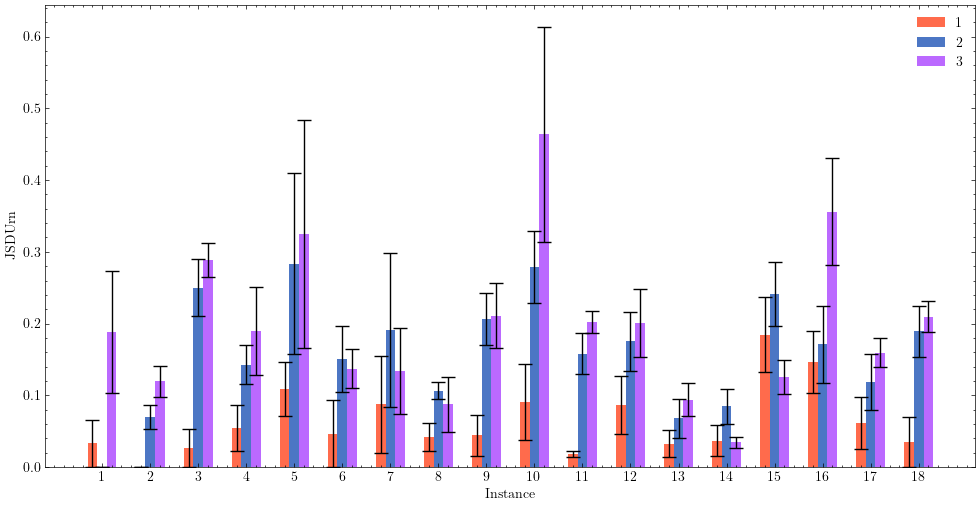

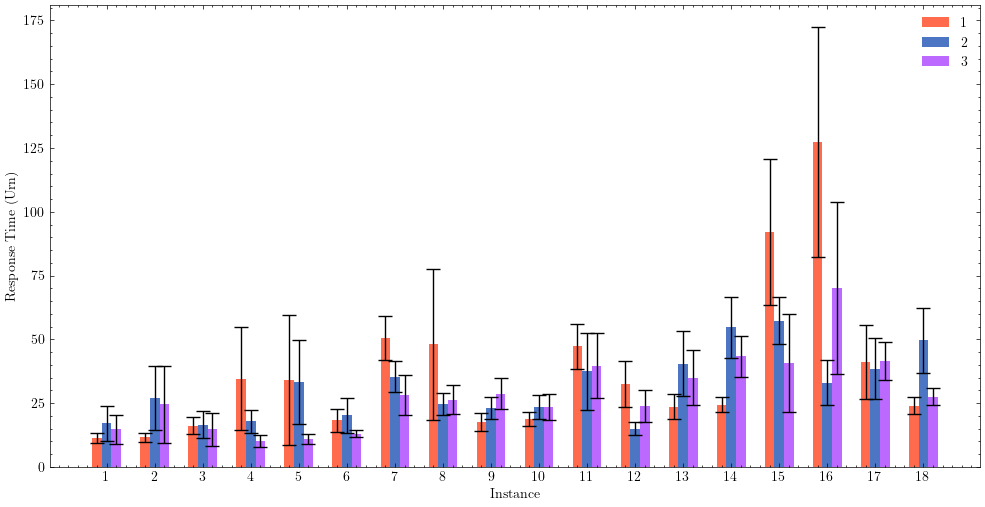

In [31]:
threeAttributes_bar(df=participant_data, lengend_var='seqBall', y_name='JSD_Urn', y_label='JSDUrn', x_name='instanceName', x_label='Instance', out=False)
threeAttributes_bar(df=participant_data, lengend_var='seqBall', y_name='responseTimeUrn', y_label='Response Time (Urn)', x_name='instanceName', x_label='Instance', out=False)

## Disaggregate According to Complexity

### Computational Complexity of each Instance

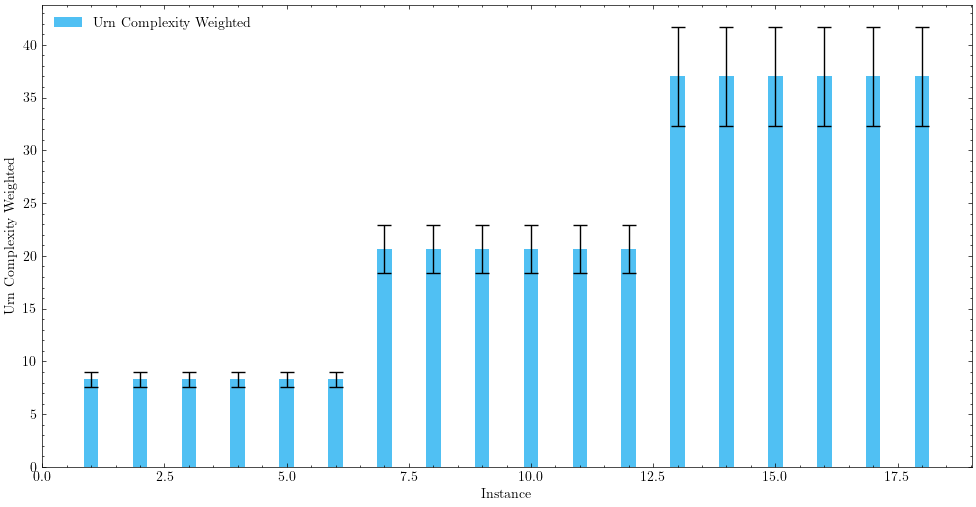

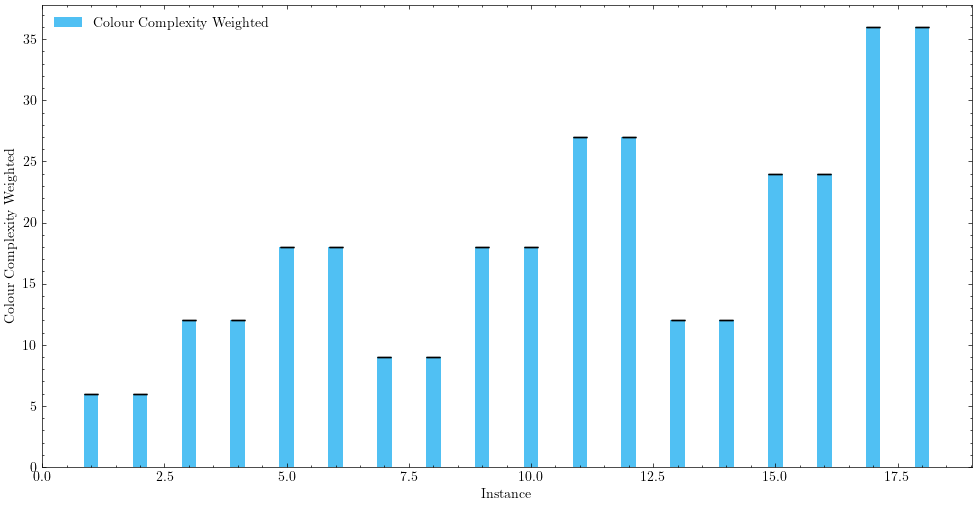

In [32]:
twoAttributes_bar(participant_data, y_name='urn_complexity_weighted', y_label='Urn Complexity Weighted', x_name='instanceName', x_label='Instance', out=False)
twoAttributes_bar(participant_data, y_name='col_complexity_weighted', y_label='Colour Complexity Weighted', x_name='instanceName', x_label='Instance', out=False)

### Decision Quality Vs Complexity

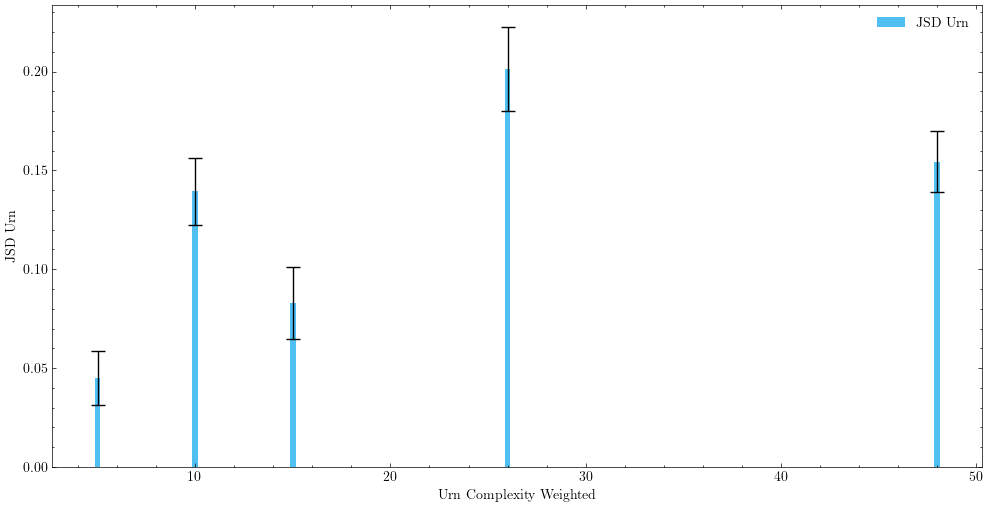

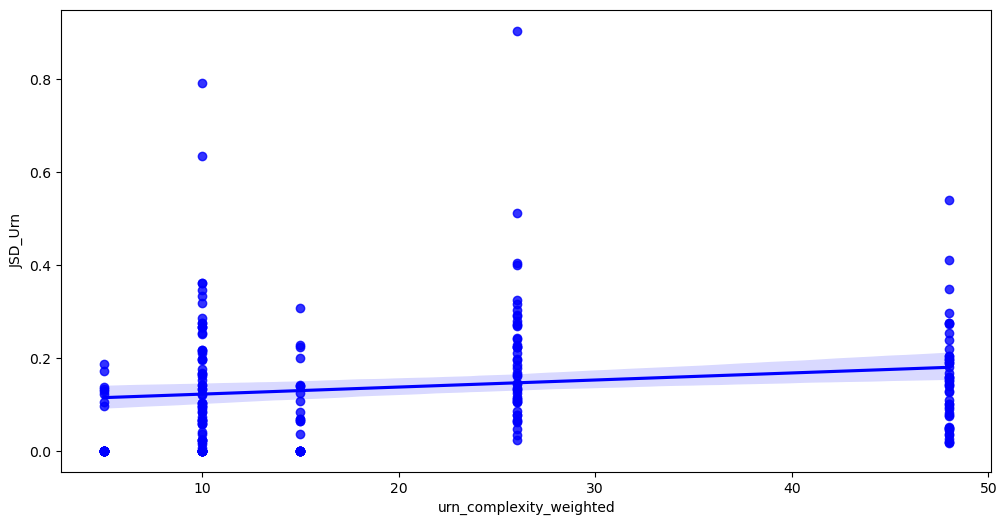

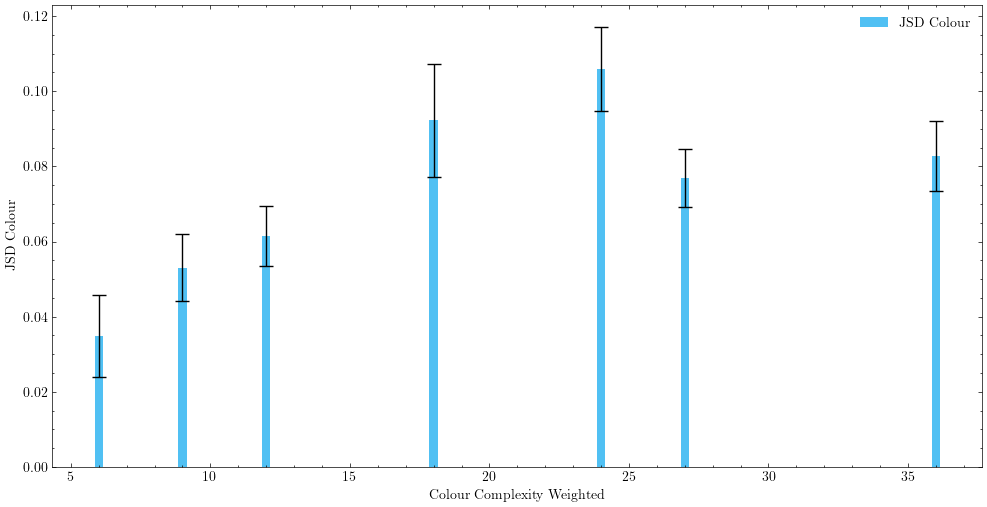

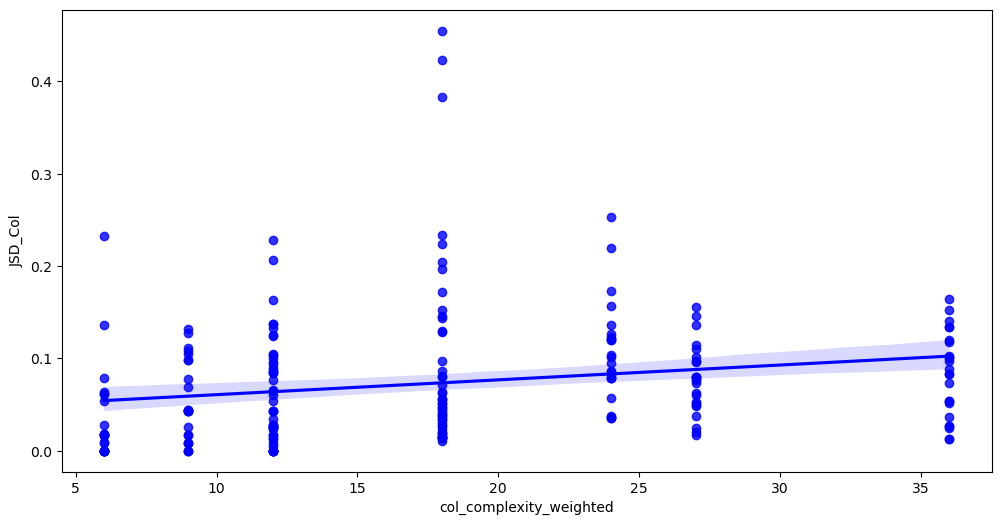

In [33]:
twoAttributes_bar(participant_data, y_name='JSD_Urn', y_label='JSD Urn', x_name='urn_complexity_weighted', x_label='Urn Complexity Weighted', out=False)
plt.figure(figsize=(12, 6), dpi=100)
sns.regplot(x='urn_complexity_weighted', y='JSD_Urn', data=participant_data, scatter=True, color='blue')
plt.show()
twoAttributes_bar(participant_data, y_name='JSD_Col', y_label='JSD Colour', x_name='col_complexity_weighted', x_label='Colour Complexity Weighted', out=False)
plt.figure(figsize=(12, 6), dpi=100)
sns.regplot(x='col_complexity_weighted', y='JSD_Col', data=participant_data, scatter=True, color='blue')
plt.show()

### Response Time Vs Complexity

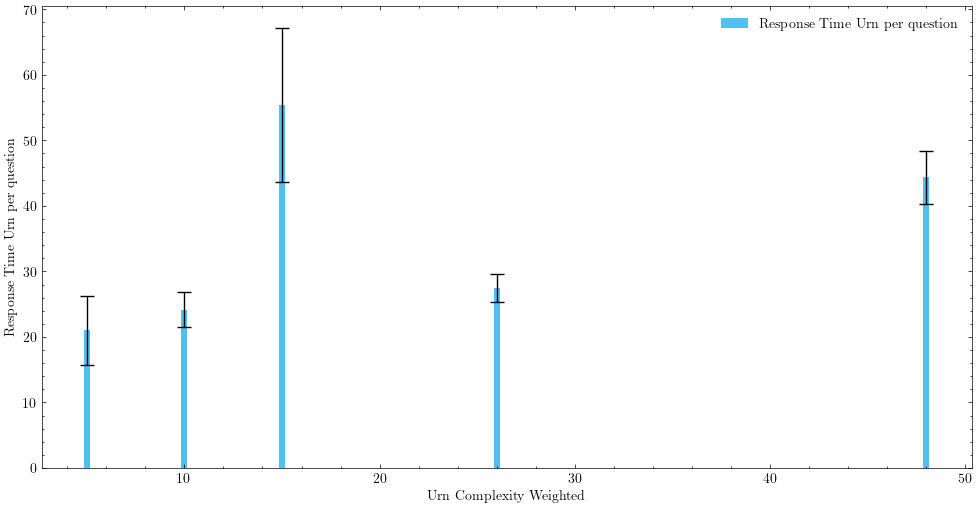

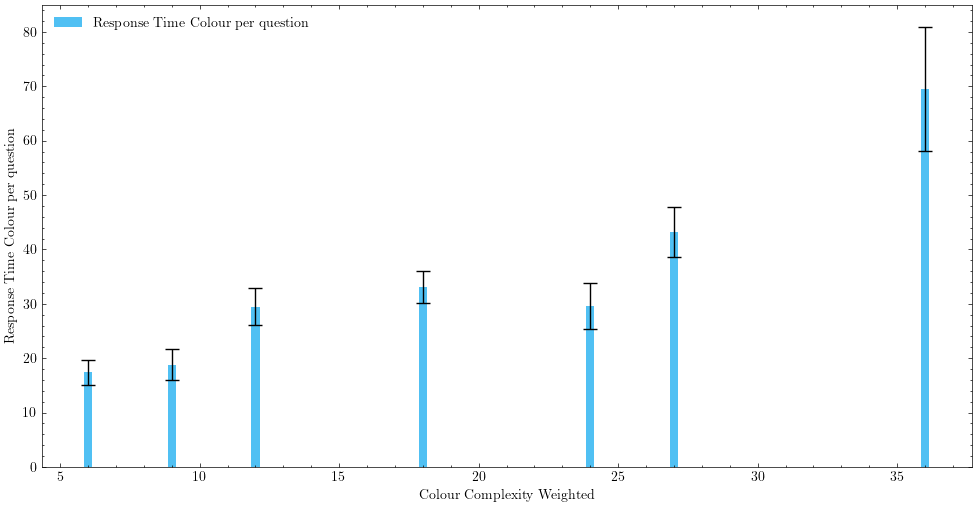

In [34]:
twoAttributes_bar(participant_data, y_name='responseTimeUrn', y_label='Response Time Urn per question', x_name='urn_complexity_weighted', x_label='Urn Complexity Weighted', out=False)
twoAttributes_bar(participant_data, y_name='responseTimeColour', y_label='Response Time Colour per question', x_name='col_complexity_weighted', x_label='Colour Complexity Weighted', out=False)

## Pool Urn Decision Quality and Complexity together

In [35]:
urnColumns = ['participantID', 'instanceName', 'responseTimeUrn', 'JSD_Urn', 
                   'urn_complexity_weighted', 'urn_complexity_MD', 'urn_complexity_total']

colColumns = ['participantID', 'instanceName', 'responseTimeColour', 'JSD_Col',
                     'col_complexity_weighted', 'col_complexity_MD', 'col_complexity_total']

urn_df = participant_data[urnColumns]
col_df = participant_data[colColumns]

urn_df['questionType'] = 'Urn'
col_df['questionType'] = 'Colour'

urnColumnNameMappings = {'responseTimeUrn': 'responseTime', 
                         'JSD_Urn': 'JSD',
                         'urn_complexity_weighted': 'complexityWeighted',
                         'urn_complexity_MD': 'complexityMD',
                         'urn_complexity_total': 'complexityTotal'}

colColumnNameMappings = {'responseTimeColour': 'responseTime',
                            'JSD_Col': 'JSD',
                            'col_complexity_weighted': 'complexityWeighted',
                            'col_complexity_MD': 'complexityMD',
                            'col_complexity_total': 'complexityTotal'}

merged_df = pd.concat([urn_df.rename(columns= urnColumnNameMappings), 
                       col_df.rename(columns= colColumnNameMappings)], 
                      ignore_index=True)



/var/folders/3k/29h810g919l7v35mx2b6pj9h0000gn/T/ipykernel_49230/3828135358.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urn_df['questionType'] = 'Urn'
/var/folders/3k/29h810g919l7v35mx2b6pj9h0000gn/T/ipykernel_49230/3828135358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col_df['questionType'] = 'Colour'


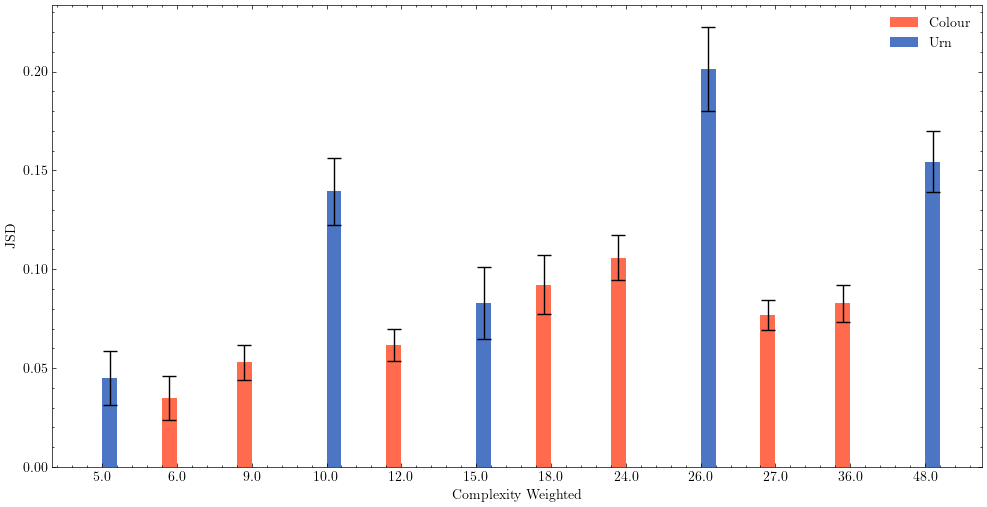

In [36]:
threeAttributes_bar(merged_df, lengend_var='questionType', y_name='JSD', y_label='JSD', x_name='complexityWeighted', x_label='Complexity Weighted', out=False)



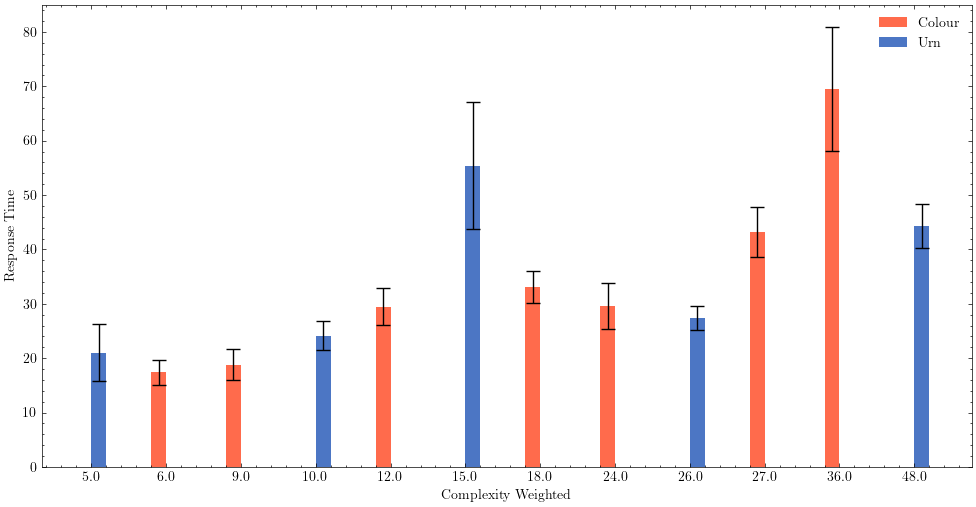

In [37]:
threeAttributes_bar(merged_df, lengend_var='questionType', y_name='responseTime', y_label='Response Time', x_name='complexityWeighted', x_label='Complexity Weighted', out=False)



## Basic Information

In [38]:
def qualityHistogram(df, title, x_name, x_label):
    '''
    Inputs: 
    df is the input dataframe
    x_name is the column name of the data to be plotted
    x_label is the label for the x-axis
    Ouputs: 
    Histogram of the data
    '''
    with plt.style.context("science"):
        plt.figure(figsize=(10, 6), dpi=100)
        plt.hist(df[x_name], bins=10, range=(0,1), color=COLORS[1], edgecolor=COLORS[1], alpha=0.7)
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel('Frequency')
        plt.xlim(0, 1)
        plt.show()



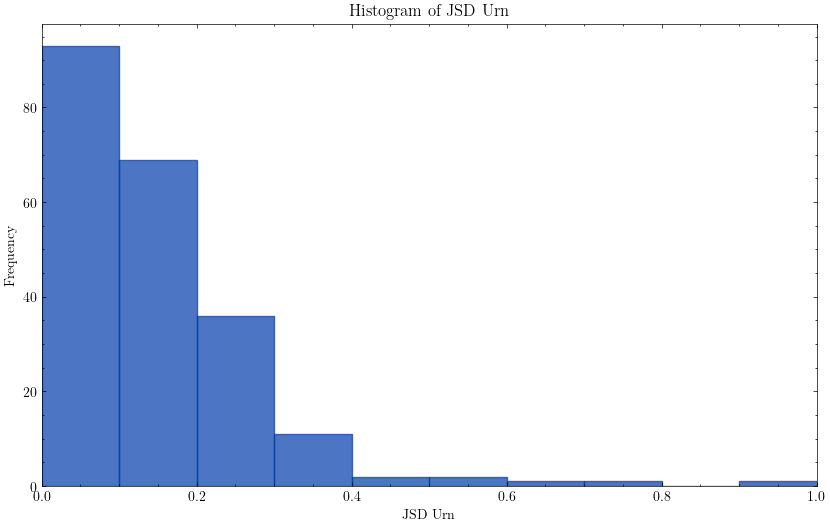

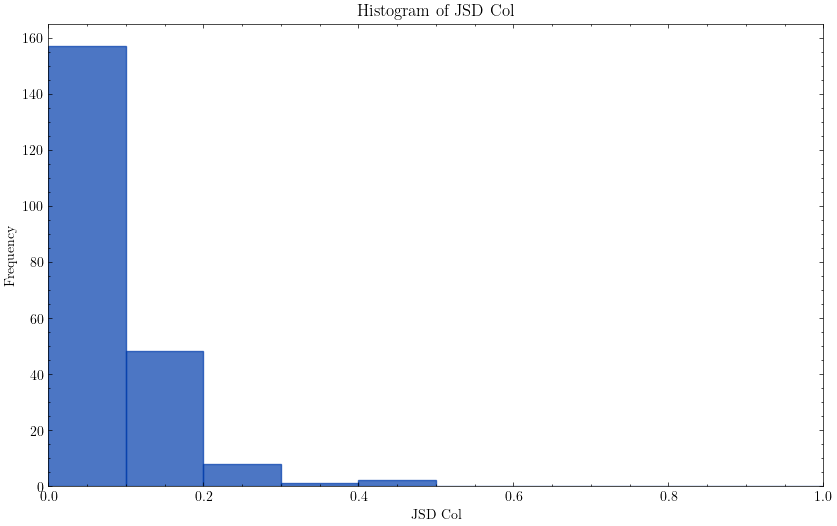

In [39]:
qualityHistogram(participant_data, 'Histogram of JSD Urn', 'JSD_Urn', 'JSD Urn')
qualityHistogram(participant_data, 'Histogram of JSD Col', 'JSD_Col', 'JSD Col')


# Regressions

In [40]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r',
       'uC_r', 'uD_r', 'uA_c', 'uB_c', 'cB_c', 'cW_c', 'cP_c', 'cG_c', 'uC_c',
       'uD_c', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB',
       'diff_cW', 'diff_cP', 'diff_cG', 'JSD_Urn', 'JSD_Col',
       'urn_complexity_total', 'urn_complexity_MD', 'urn_complexity_weighted',
       'col_complexity_total', 'col_complexity_MD', 'col_complexity_weighted'],
      dtype='object')

In [41]:
# Define the model
model = mixedlm("JSD_Urn ~ urn_complexity_weighted", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    JSD_Urn 
No. Observations:     216        Method:                REML    
No. Groups:           4          Scale:                 0.0171  
Min. group size:      54         Log-Likelihood:        123.0899
Max. group size:      54         Converged:             Yes     
Mean group size:      54.0                                      
----------------------------------------------------------------
                        Coef. Std.Err.   z   P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept               0.106    0.016 6.685 0.000  0.075  0.137
urn_complexity_weighted 0.002    0.001 2.636 0.008  0.000  0.003
Group Var               0.000    0.002                          



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [42]:
# Define the model
model = mixedlm("JSD_Urn ~ urn_complexity_weighted + responseTimeUrn", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg


              Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     JSD_Urn 
No. Observations:     216         Method:                 REML    
No. Groups:           4           Scale:                  0.0172  
Min. group size:      54          Log-Likelihood:         115.9578
Max. group size:      54          Converged:              No      
Mean group size:      54.0                                        
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                0.109    0.017  6.296 0.000  0.075  0.143
urn_complexity_weighted  0.002    0.001  2.641 0.008  0.000  0.003
responseTimeUrn         -0.000    0.000 -0.366 0.715 -0.001  0.001
Group Var                0.000    0.002                           



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2207: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2219: ConvergenceWarning: Gradient optimization failed, |grad| = 0.098307
  warnings.warn(msg, ConvergenceWarning)
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [43]:
# Define the model
model = mixedlm("JSD_Col ~ col_complexity_weighted", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    JSD_Col 
No. Observations:     216        Method:                REML    
No. Groups:           4          Scale:                 0.0041  
Min. group size:      54         Log-Likelihood:        273.6281
Max. group size:      54         Converged:             Yes     
Mean group size:      54.0                                      
----------------------------------------------------------------
                        Coef. Std.Err.   z   P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept               0.045    0.016 2.841 0.004  0.014  0.075
col_complexity_weighted 0.002    0.000 3.338 0.001  0.001  0.003
Group Var               0.001    0.009                          



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [44]:
# Define the model
model = mixedlm("JSD_Col ~ col_complexity_weighted + responseTimeColour", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     JSD_Col 
No. Observations:     216         Method:                 REML    
No. Groups:           4           Scale:                  0.0041  
Min. group size:      54          Log-Likelihood:         266.2467
Max. group size:      54          Converged:              Yes     
Mean group size:      54.0                                        
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                0.046    0.015  2.958 0.003  0.015  0.076
col_complexity_weighted  0.002    0.001  3.353 0.001  0.001  0.003
responseTimeColour      -0.000    0.000 -0.862 0.389 -0.000  0.000
Group Var                0.001    0.008                           



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# Other Things

In [45]:
import time

start_time = time.time()
for i in range(100000000):
    result = 0.25 * 0.33
end_time = time.time()

time_consumed = end_time - start_time
print(f"Time consumed for calculating: {time_consumed} seconds")

Time consumed for calculating: 2.5573408603668213 seconds


In [46]:
import time

start_time = time.time()
result = 0
for i in range(100000000):
    result = 0.25 + 0.33
end_time = time.time()

time_consumed = end_time - start_time
print(f"Time consumed for calculating: {time_consumed} seconds")

Time consumed for calculating: 2.5635950565338135 seconds
